In [ ]:
# pip install matplotlib seaborn

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from lxml import etree
import xml.etree.ElementTree as ET
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
import re

import torch
import torch.nn as nn
from transformers import BertModel
from torch.autograd import Function
import torch.optim as optim
import csv

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, RobertaTokenizer
import argparse
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# **Seeds**

In [ ]:
seed = 168
train_seed = 168

# **Utility Functions**

In [ ]:
class EarlyStopper:
    def __init__(self, patience=2, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class InputFeatures(object):
    def __init__(self, input_ids, input_mask, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.label_id = label_id

def CSV2Array(path):
    data = pd.read_csv(path, encoding='latin')
    reviews, labels = data.reviews.values.tolist(), data.labels.values.tolist()
    return reviews, labels

def make_cuda(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

def init_model(net, restore=None):
    # check if cuda is available
    if torch.cuda.is_available():
        cudnn.benchmark = True
        net.cuda()
    return net

def text2features(reviews, labels, max_seq_length, tokenizer,
                                 cls_token='[CLS]', sep_token='[SEP]',
                                 pad_token=0):
    features = []
    for ex_index, (review, label) in enumerate(zip(reviews, labels)):
        tokens = tokenizer.tokenize(review)
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[:(max_seq_length - 2)]
        tokens = [cls_token] + tokens + [sep_token]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        input_ids = input_ids + ([pad_token] * padding_length)
        input_mask = input_mask + ([0] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length

        features.append(
            InputFeatures(input_ids=input_ids,
                          input_mask=input_mask,
                          label_id=label))
    return features

def get_data_loader(features, batch_size, for_training = True):
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_input_mask, all_label_ids)
    if for_training:
        # For training
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        # For testing
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.device_count() > 0:
        torch.cuda.manual_seed_all(seed)

def plot_1(col, title, label, xlabel, ylabel):
    epochs = range(1, len(col) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, col, color='b', label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_2(col1, col2, title, label1, label2, xlabel, ylabel, start_from_zero = False):
    if start_from_zero:
        epochs = range(0, len(col1))
    else:
        epochs = range(1, len(col1)+1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, col1, color='blue', label=label1)
    plt.plot(epochs, col2, color='orange', label=label2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# **Model Definition**

In [ ]:
# Gradient Reversal Layer
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

# BERT encoder as Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.encoder = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, x, mask=None):
        outputs = self.encoder(x, attention_mask=mask)
        feat = outputs[1]
        return feat

# Label Classifier for Sentiment Analysis
class LabelClassifier(nn.Module):
    def __init__(self, hidden_size=768, num_labels=3, dropout=0.1):
        super(LabelClassifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.apply(self.initialize_weights)

    def forward(self, x):
        x = self.dropout(x)
        out = self.classifier(x)
        return out

    def initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

# Domain Clasifier as Discriminator
class DomainClassifier(nn.Module):
    def __init__(self, hidden_size=768, dropout=0.1):
        super(DomainClassifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(hidden_size, 2)
        self.apply(self.initialize_weights)

    def forward(self, x, alpha):
        x = self.dropout(x)
        x = GradientReversalLayer.apply(x, alpha)
        out = self.classifier(x)
        return out

    def initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

# **Train & Evaluation Loop**

In [ ]:
def train(encoder, cls_classifier, dom_classifier, src_data_loader, src_data_loader_eval, tgt_data_loader, tgt_data_loader_test):
    train_src_acc, test_src_acc, train_tgt_acc, test_tgt_acc = [], [], [], []
    train_src_loss, test_src_loss, train_tgt_loss, test_tgt_loss = [], [], [], []
    total_loss, domain_loss = [], []

    # Hyperparameters
    weight_decay_constant = 1e-4
    alpha = 1e-3
    num_epochs = 10
    learning_rate = 2e-5

    # Loss and Optimizer
    CELoss = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        list(encoder.parameters()) +
        list(cls_classifier.parameters()) +
        list(dom_classifier.parameters()),
        lr=learning_rate,
        weight_decay=weight_decay_constant
    )

    # Initialize Early Stopper
    early_stopper = EarlyStopper()

    # Log performance before training
    eval_src_loss, eval_src_acc = evaluate(encoder, cls_classifier, src_data_loader_eval)
    print("Avg source loss = %.4f, Avg source accuracy = %.4f" % (eval_src_loss, eval_src_acc))
    epoch_train_src_loss, epoch_train_src_acc = evaluate(encoder, cls_classifier, src_data_loader)
    epoch_train_tgt_loss, epoch_train_tgt_acc = evaluate(encoder, cls_classifier, tgt_data_loader)
    eval_tgt_loss, eval_tgt_acc = evaluate(encoder, cls_classifier, tgt_data_loader_test)
    print("Avg target loss = %.4f, Avg target accuracy = %.4f" % (eval_tgt_loss, eval_tgt_acc))
    train_src_acc.append(epoch_train_src_acc)
    test_src_acc.append(eval_src_acc)
    train_tgt_acc.append(epoch_train_tgt_acc)
    test_tgt_acc.append(eval_tgt_acc)
    train_src_loss.append(epoch_train_src_loss)
    test_src_loss.append(eval_src_loss)
    train_tgt_loss.append(epoch_train_tgt_loss)
    test_tgt_loss.append(eval_tgt_loss)

    for epoch in range(num_epochs):
        epoch_total_loss, epoch_domain_loss, epoch_train_src_loss, epoch_train_tgt_loss = 0, 0, 0, 0
        print(f"Epoch: {epoch}")

        # set train state
        encoder.train()
        cls_classifier.train()
        dom_classifier.train()
        data_zip = enumerate(zip(src_data_loader, tgt_data_loader))
        for step, ((src_reviews, src_mask, src_labels), (tgt_reviews, tgt_mask, tgt_labels)) in data_zip:
            src_reviews = make_cuda(src_reviews)
            src_mask = make_cuda(src_mask)
            src_labels = make_cuda(src_labels)
            tgt_reviews = make_cuda(tgt_reviews)
            tgt_mask = make_cuda(tgt_mask)
            tgt_labels = make_cuda(tgt_labels)

            # Feature Extraction & Prediction
            src_feat = encoder(src_reviews, src_mask)
            tgt_feat = encoder(tgt_reviews, tgt_mask)
            feat_concat = torch.cat((src_feat, tgt_feat), 0)
            src_preds = cls_classifier(src_feat)
            dom_preds = dom_classifier(feat_concat, alpha=alpha)

            # Label and Domain Loss
            optimizer.zero_grad()
            label_src = make_cuda(torch.ones(src_feat.size(0))) # 1 is src
            label_tgt = make_cuda(torch.zeros(tgt_feat.size(0))) # 0 is target domain
            label_concat = torch.cat((label_src, label_tgt), 0).long()
            loss_cls = CELoss(src_preds, src_labels)
            loss_dom = CELoss(dom_preds, label_concat)
            loss_tgt_cls = CELoss(cls_classifier(tgt_feat), tgt_labels)
            loss = loss_cls + loss_dom + loss_tgt_cls

            # Back Propagation
            loss.backward()
            optimizer.step()

            epoch_total_loss, epoch_domain_loss, epoch_train_src_loss, epoch_train_tgt_loss = loss.item(), loss_dom.item(), loss_cls.item(), loss_tgt_cls.item()
            if (step + 1) % 500 == 0:
                print("Epoch [%.2d/%.2d] Step [%.3d/%.3d]: cls_loss=%.4f dom_loss=%.4f tgt_cls_loss=%.4f"
                      % (epoch + 1, num_epochs, step + 1, len(src_data_loader), loss_cls.item(), loss_dom.item(), loss_tgt_cls.item()))

        # Epoch Evaluation
        eval_src_loss, eval_src_acc = evaluate(encoder, cls_classifier, src_data_loader_eval)
        print("Avg src loss = %.4f, Avg src accuracy = %.4f" % (eval_src_loss, eval_src_acc))
        epoch_train_src_loss, epoch_train_src_acc = evaluate(encoder, cls_classifier, src_data_loader)
        epoch_train_tgt_loss, epoch_train_tgt_acc = evaluate(encoder, cls_classifier, tgt_data_loader)

        eval_tgt_loss, eval_tgt_acc = evaluate(encoder, cls_classifier, tgt_data_loader_test)
        print("Avg target loss = %.4f, Avg target accuracy = %.4f" % (eval_tgt_loss, eval_tgt_acc))

        # Record Logs
        train_src_acc.append(epoch_train_src_acc)
        test_src_acc.append(eval_src_acc)
        train_tgt_acc.append(epoch_train_tgt_acc)
        test_tgt_acc.append(eval_tgt_acc)
        train_src_loss.append(epoch_train_src_loss)
        test_src_loss.append(eval_src_loss)
        train_tgt_loss.append(epoch_train_tgt_loss)
        test_tgt_loss.append(eval_tgt_loss)
        total_loss.append(epoch_total_loss)
        domain_loss.append(epoch_domain_loss)

        # Early stopping
        if early_stopper.early_stop(eval_tgt_loss):
            print("Early stopping triggered!")
            break

    logs = {
        "train_src_acc": train_src_acc,
        "test_src_acc": test_src_acc,
        "train_tgt_acc": train_tgt_acc,
        "test_tgt_acc": test_tgt_acc,
        "train_src_loss": train_src_loss,
        "test_src_loss": test_src_loss,
        "train_tgt_loss": train_tgt_loss,
        "test_tgt_loss": test_tgt_loss,
        "total_loss": total_loss,
        "domain_loss": domain_loss
    }
    return encoder, cls_classifier, dom_classifier, logs

def evaluate(encoder, classifier, data_loader, get_confusion_metric = False):
    encoder.eval()
    classifier.eval()

    # Initialize loss and accuracy
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []

    # Set loss function
    criterion = nn.CrossEntropyLoss()

    # Evaluate network
    for (reviews, mask, labels) in data_loader:
        reviews = make_cuda(reviews)
        mask = make_cuda(mask)
        labels = make_cuda(labels)

        with torch.no_grad():
            feat = encoder(reviews, mask)
            preds = classifier(feat)

        # Calculate loss
        total_loss += criterion(preds, labels).item()

        # Get predictions and true labels
        pred_cls = preds.data.max(1)[1]  # Get the predicted class with highest score
        all_preds.extend(pred_cls.cpu().numpy())  # Store predicted labels
        all_labels.extend(labels.cpu().numpy())  # Store true labels

        # Calculate accuracy
        total_acc += pred_cls.eq(labels.data).cpu().sum().item()

    # Average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_acc / len(data_loader.dataset)

    if get_confusion_metric:
        # Calculate confusion matrix and F1 score
        conf_matrix = confusion_matrix(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return avg_loss, avg_acc, conf_matrix, f1
    else:
        return avg_loss, avg_acc

# **Run**

In [ ]:
set_seed(train_seed)

# Parameters
max_seq_length = 75
batch_size = 128

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load twitter data as source data
src_x, src_y = CSV2Array('./preprocessed_twitter.csv')
src_x, src_test_x, src_y, src_test_y = train_test_split(src_x, src_y, test_size=0.2, stratify=src_y, random_state=seed)
# Load financial data as target data
tgt_x, tgt_y = CSV2Array('./preprocessed_financial.csv')
tgt_train_x, tgt_test_x, tgt_train_y, tgt_test_y = train_test_split(tgt_x, tgt_y, test_size=0.25, stratify=tgt_y, random_state=seed)
# Generate features
src_features = text2features(src_x, src_y, max_seq_length, tokenizer)
src_test_features = text2features(src_test_x, src_test_y, max_seq_length, tokenizer)
tgt_features = text2features(tgt_train_x, tgt_train_y, max_seq_length, tokenizer)
tgt_test_features = text2features(tgt_test_x, tgt_test_y, max_seq_length, tokenizer)

# Get dataset size
src_size = len(src_features)
tgt_size = len(tgt_features)

# Create Data Loader
tgt_data_loader_batch_size = math.ceil((tgt_size/src_size) * batch_size)
src_data_loader = get_data_loader(src_features, batch_size, for_training = True)
src_data_loader_eval = get_data_loader(src_test_features, batch_size, for_training = False)
tgt_data_loader = get_data_loader(tgt_features, tgt_data_loader_batch_size, for_training = True)
tgt_data_loader_test = get_data_loader(tgt_test_features, batch_size, for_training = False)

# load models
encoder = FeatureExtractor()
cls_classifier = LabelClassifier()
dom_classifier = DomainClassifier()
encoder = init_model(encoder)
cls_classifier = init_model(cls_classifier)
dom_classifier = init_model(dom_classifier)

print("=== Start Training ===")
encoder, cls_classifier, dom_classifier, logs = train(encoder, cls_classifier, dom_classifier, src_data_loader, src_data_loader_eval, tgt_data_loader, tgt_data_loader_test)

=== Start Training ===
Avg source loss = 1.1960, Avg source accuracy = 0.2260
Avg target loss = 1.2206, Avg target accuracy = 0.1262
Epoch: 0
Epoch [01/10] Step [500/1019]: cls_loss=0.3466 dom_loss=0.2151 tgt_cls_loss=0.1713
Avg src loss = 0.2425, Avg src accuracy = 0.9229
Avg target loss = 0.4164, Avg target accuracy = 0.8399
Epoch: 1
Epoch [02/10] Step [500/1019]: cls_loss=0.1353 dom_loss=0.1804 tgt_cls_loss=0.1432
Avg src loss = 0.1447, Avg src accuracy = 0.9544
Avg target loss = 0.4361, Avg target accuracy = 0.8226
Epoch: 2
Epoch [03/10] Step [500/1019]: cls_loss=0.0576 dom_loss=0.2035 tgt_cls_loss=0.1362
Avg src loss = 0.0996, Avg src accuracy = 0.9702
Avg target loss = 0.5513, Avg target accuracy = 0.8449
Early stopping triggered!


In [ ]:
print("=== Final Evaluation ===")
final_test_loss, tinal_test_acc, conf_matrix, f1 = evaluate(encoder, cls_classifier, tgt_data_loader_test, True)
print("Avg target loss = %.4f, Avg target accuracy = %.4f" % (final_test_loss, tinal_test_acc))

=== Final Evaluation ===
Avg target loss = 0.5513, Avg target accuracy = 0.8449


# **Plot: Total Loss over Epochs**

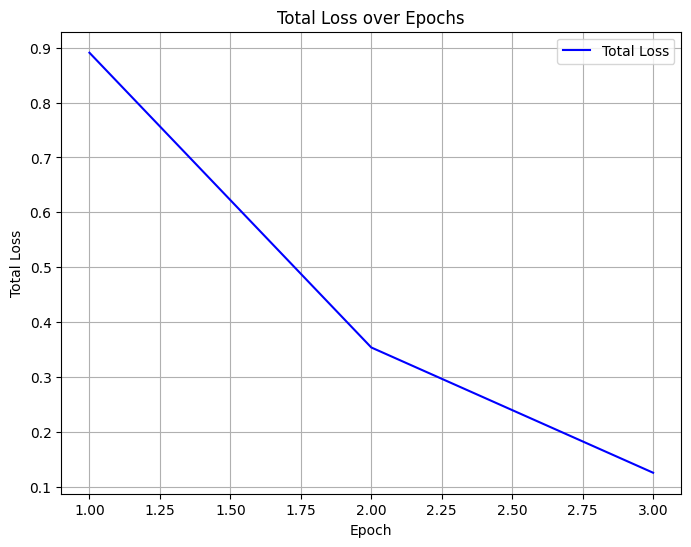

In [ ]:
# Plot Total Loss
plot_1(logs['total_loss'], title="Total Loss over Epochs", label="Total Loss", xlabel="Epoch", ylabel="Total Loss")

# **Plot: Train & Test Sentiment Classification Loss (Financial vs Reddit )over Epochs**

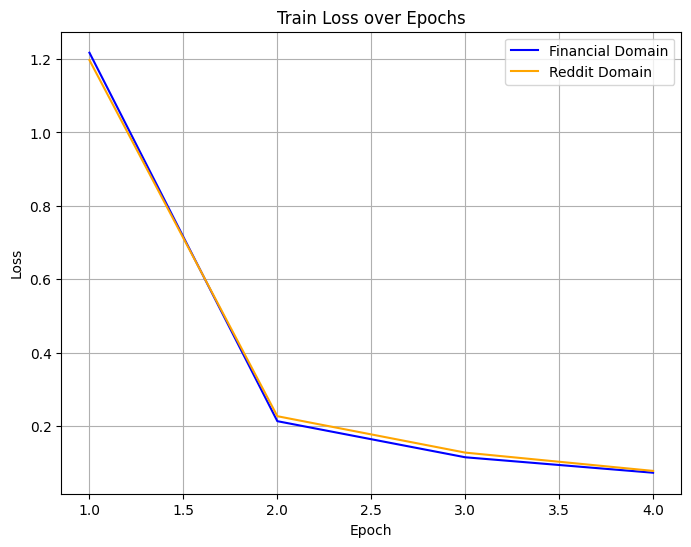

In [ ]:
# Plot train loss
plot_2(col1 = logs['train_tgt_loss'], col2=logs["train_src_loss"], title="Train Loss over Epochs", label1="Financial Domain", label2="Reddit Domain", xlabel="Epoch", ylabel="Loss")

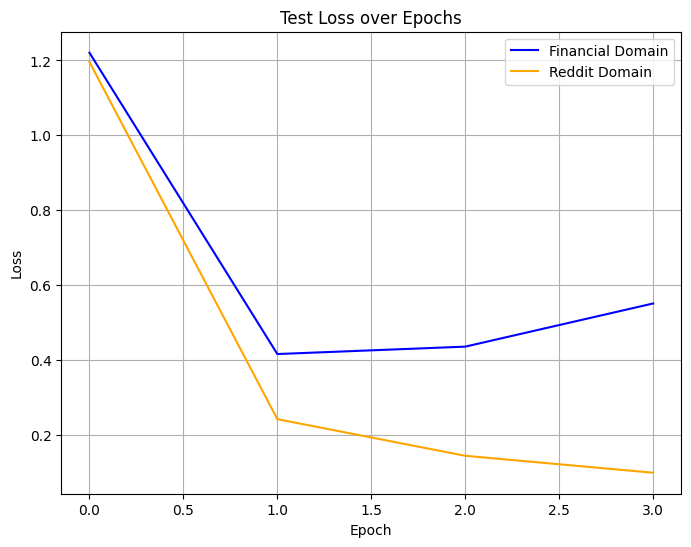

In [ ]:
# Plot test loss
plot_2(col1 = logs['test_tgt_loss'], col2=logs["test_src_loss"], title="Test Loss over Epochs", label1="Financial Domain", label2="Reddit Domain", xlabel="Epoch", ylabel="Loss", start_from_zero=True)

# **Plot: Train & Test Sentiment Classification Accuracy (Financial vs Reddit ) over Epochs**

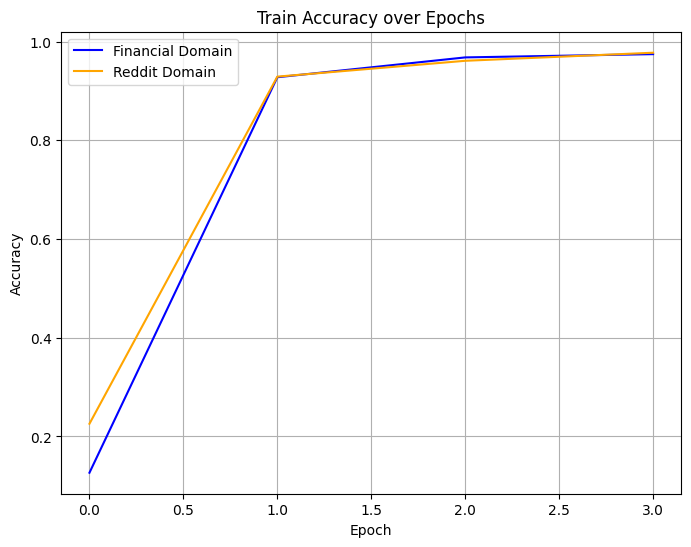

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['train_tgt_acc'], col2=logs["train_src_acc"], title="Train Accuracy over Epochs", label1="Financial Domain", label2="Reddit Domain", xlabel="Epoch", ylabel="Accuracy", start_from_zero=True)

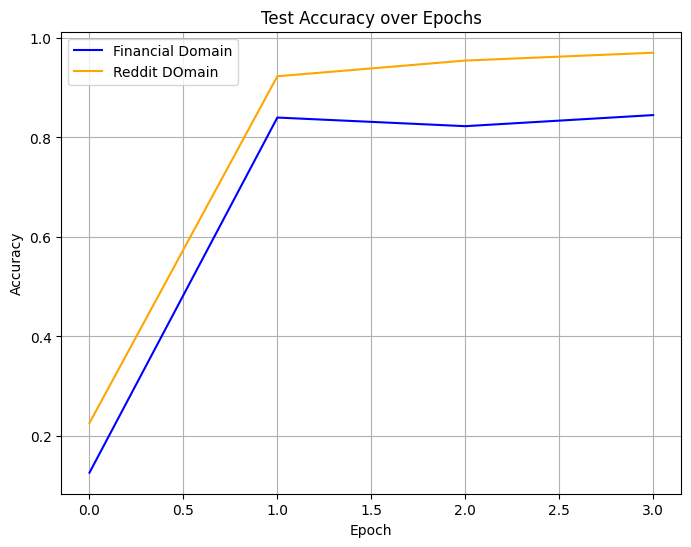

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['test_tgt_acc'], col2=logs["test_src_acc"], title="Test Accuracy over Epochs", label1="Financial Domain", label2="Reddit DOmain", xlabel="Epoch", ylabel="Accuracy", start_from_zero=True)

# **Plot: Train & Test Sentiment Classification Loss (Reddit ) over Epochs**

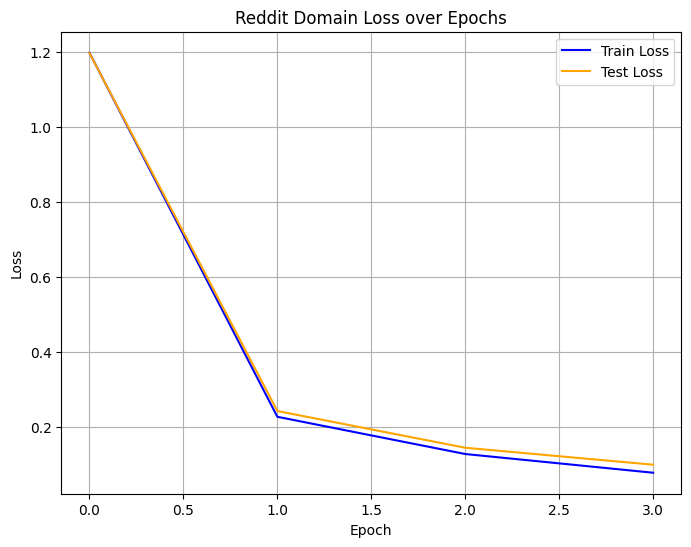

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['train_src_loss'], col2=logs["test_src_loss"], title="Reddit Domain Loss over Epochs", label1="Train Loss", label2="Test Loss", xlabel="Epoch", ylabel="Loss", start_from_zero=True)

# **Plot: Train & Test Sentiment Classification Accuracy (Reddit ) over Epochs**

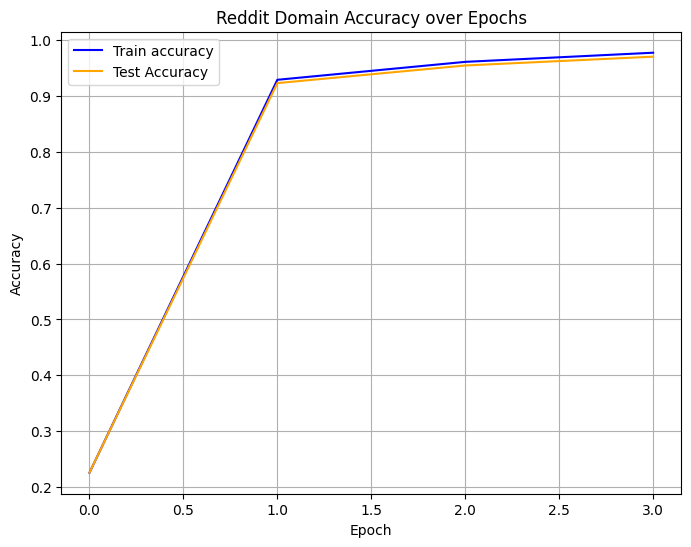

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['train_src_acc'], col2=logs["test_src_acc"], title="Reddit Domain Accuracy over Epochs", label1="Train accuracy", label2="Test Accuracy", xlabel="Epoch", ylabel="Accuracy", start_from_zero=True)

# **Plot: Train & Test Sentiment Classification Loss (Financial ) over Epochs**

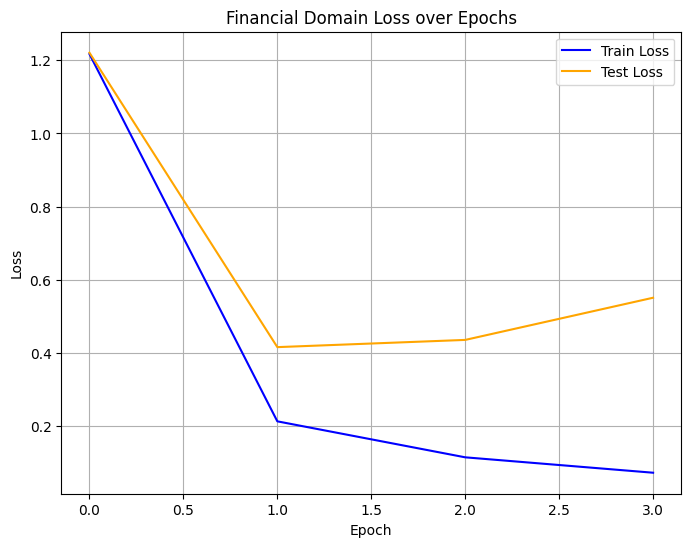

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['train_tgt_loss'], col2=logs["test_tgt_loss"], title="Financial Domain Loss over Epochs", label1="Train Loss", label2="Test Loss", xlabel="Epoch", ylabel="Loss", start_from_zero=True)

# **Plot: Train & Test Sentiment Classification Accuracy (Financial ) over Epochs**

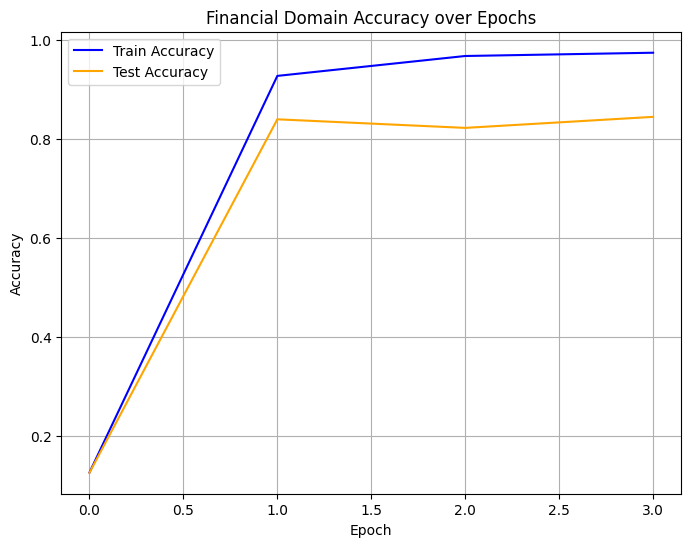

In [ ]:
# Plot test accuracy
plot_2(col1 = logs['train_tgt_acc'], col2=logs["test_tgt_acc"], title="Financial Domain Accuracy over Epochs", label1="Train Accuracy", label2="Test Accuracy", xlabel="Epoch", ylabel="Accuracy", start_from_zero=True)

# **Confusion Matrix & F1 Score**

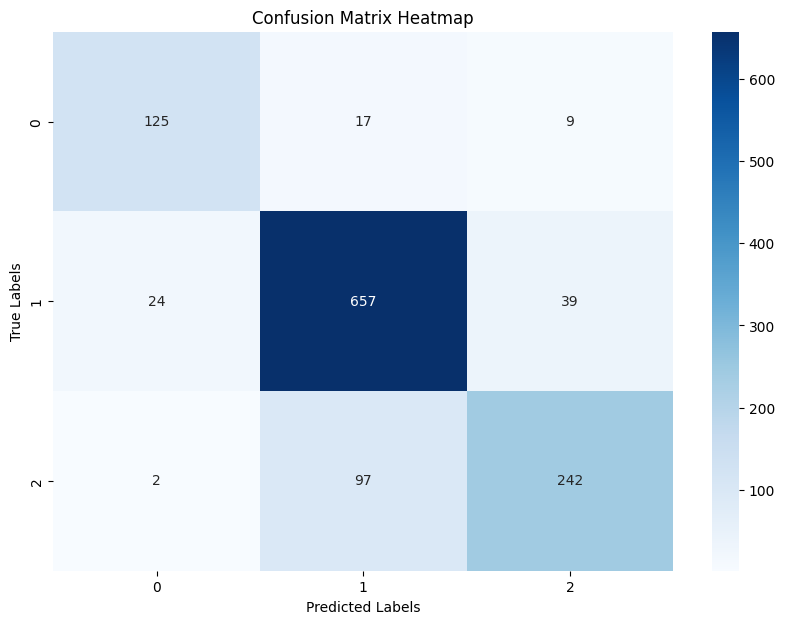

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=[f'{i}' for i in range(conf_matrix.shape[1])],
            yticklabels=[f'{i}' for i in range(conf_matrix.shape[0])])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
print(f"f1 score: {f1}")

f1 score: 0.8424806868439668
